In [58]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [59]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

# Step 1. 실험환경 Set-up
# BATCH_SIZE = 64
# EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


In [60]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [61]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [62]:
# Step 5. 데이터 imbalance 처리 
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [63]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [64]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [65]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [66]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [67]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [68]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [69]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [70]:
# Step 2. 데이터 준비하기
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

In [71]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

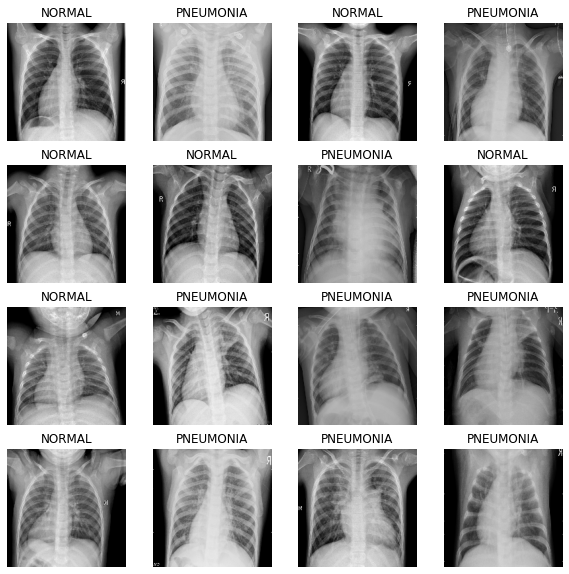

In [72]:
# Step 3. 데이터 시각화
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [73]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [33]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [34]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [82]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [36]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [37]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 68s 208ms/step - loss: 0.4088 - accuracy: 0.7938 - precision: 0.9562 - recall: 0.7578 - val_loss: 0.6367 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 55s 210ms/step - loss: 0.2427 - accuracy: 0.9033 - precision: 0.9704 - recall: 0.8974 - val_loss: 0.9238 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 209ms/step - loss: 0.2003 - accuracy: 0.9236 - precision: 0.9755 - recall: 0.9205 - val_loss: 0.1568 - val_accuracy: 0.9404 - val_precision: 0.9288 - val_recall: 0.9947
Epoch 4/10
261/261 [==============================] - 55s 212ms/step - loss: 0.2007 - accuracy: 0.9286 - precision: 0.9786 - recall: 0.9244 - val_loss: 0.1569 - val_accuracy: 0.9337 - val_precision: 0.9182 - val_recall: 0.9987
Epoch 5/10
261/261 [==============================] - 56s 216ms/step - loss: 0.1757 - accura

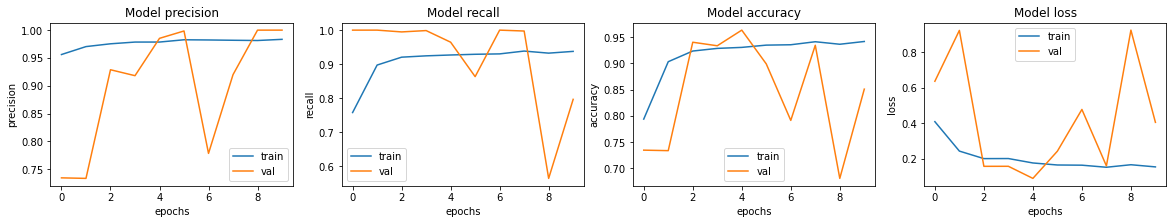

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [39]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 123ms/step - loss: 0.4075 - accuracy: 0.8574 - precision: 0.9013 - recall: 0.8667
Loss: 0.40754276514053345,
Accuracy: 0.8573718070983887,
Precision: 0.9013333320617676,
Recall: 0.8666666746139526


In [ ]:
# Step 4. ResNet-18 구현

In [92]:
def residual_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, (3,3), padding='same', activation='relu' ),
        tf.keras.layers.Conv2D(filters, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters, (3,3), padding='same', activation='relu')
    ])

    return block

In [100]:
def build_model2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(64, (7,7), strides=2 ,padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=2 ,padding='same'),
        
        residual_block(64),
        
        tf.keras.layers.BatchNormalization(),
        
        residual_block(128),
        
        tf.keras.layers.BatchNormalization(),
        
        residual_block(256),
        
        tf.keras.layers.BatchNormalization(),
        
        residual_block(512),
        
        tf.keras.layers.AveragePooling2D(pool_size=(7, 7)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(units= (2* 1000), activation='relu'),
                       
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [101]:
with tf.device('/GPU:0'):
    model2 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [102]:
# Step 6. 모델 훈련
with tf.device('/GPU:0'):
    history = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/10
261/261 [==============================] - 85s 274ms/step - loss: 0.9757 - accuracy: 0.8494 - precision: 0.8597 - recall: 0.9530 - val_loss: 1.4347 - val_accuracy: 0.8337 - val_precision: 0.8369 - val_recall: 0.9607
Epoch 2/10
261/261 [==============================] - 73s 280ms/step - loss: 0.2191 - accuracy: 0.9198 - precision: 0.9409 - recall: 0.9521 - val_loss: 0.1845 - val_accuracy: 0.9269 - val_precision: 0.9791 - val_recall: 0.9201
Epoch 3/10
261/261 [==============================] - 74s 284ms/step - loss: 0.1753 - accuracy: 0.9370 - precision: 0.9552 - recall: 0.9604 - val_loss: 0.2527 - val_accuracy: 0.8856 - val_precision: 0.9864 - val_recall: 0.8560
Epoch 4/10
261/261 [==============================] - 74s 286ms/step - loss: 0.1305 - accuracy: 0.9511 - precision: 0.9678 - recall: 0.9665 - val_loss: 0.2074 - val_accuracy: 0.9385 - val_precision: 0.9730 - val_recall: 0.9424
Epoch 5/10
261/261 [==============================] - 74s 285ms/step - loss: 0.1294 - accura

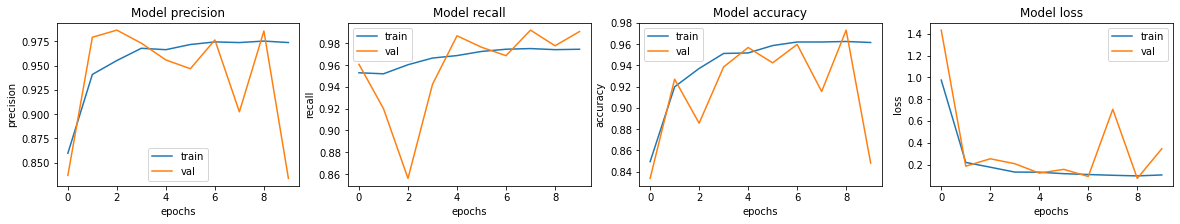

In [103]:
# Step 7. 결과 확인과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [110]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 120ms/step - loss: 1.0789 - accuracy: 0.6603 - precision: 0.6483 - recall: 0.9974
Loss: 1.0789271593093872,
Accuracy: 0.6602563858032227,
Precision: 0.6483333110809326,
Recall: 0.9974358677864075


In [111]:
# epoch를 할때마다 Accuracy 증가하고 loss가 감소하며 Recall(의료데이터이기때문에 precision보다 Recall)또한 증가 하기 때문에 epoch를 늘릴시 성능 향상을 기대할 수 있을 것으로 본다.
# 다만 val데이터에 대해 데이터량이 적어 들쑥날쑥한 결과값을 나타내는 것으로 예상되며 imbalance를 통한 val 데이터의 증가와 이상치값을 제외한다면 또한 성능 향상을 기대할 수 있을 것으로 본다.

In [31]:
# model2(ResNet-18)의 add layer구현(함수형이나 클래스형으로 변경하면 가능하나 시간상 구현 못함)과 imbalance를 적용시키지 못함